In [35]:
%config InlineBackend.figure_formats = ['svg']
import xyzpy as xyz
import quimb as qu
import quimb.tensor as qtn
from quimb.experimental.operatorbuilder import *

In [36]:
Lx = 4
Ly = 3
N = Lx * Ly
num_up = 6
num_down = 6
subspace = ((N, num_up), (N, num_down))

In [37]:
edges = qtn.edges_2d_square(Lx, Ly)
H = fermi_hubbard_from_edges(edges)
H.show()

SparseOperatorBuilder(nsites=24, nterms=80, locality=4))
+ - . . . . . . . . . . . . . . . . . . . . . .  -1.0
- + . . . . . . . . . . . . . . . . . . . . . .  -1.0
. . . . . . . . . . . . + - . . . . . . . . . .  -1.0
. . . . . . . . . . . . - + . . . . . . . . . .  -1.0
+ z z - . . . . . . . . . . . . . . . . . . . .  -1.0
- z z + . . . . . . . . . . . . . . . . . . . .  -1.0
. . . . . . . . . . . . + z z - . . . . . . . .  -1.0
. . . . . . . . . . . . - z z + . . . . . . . .  -1.0
. + - . . . . . . . . . . . . . . . . . . . . .  -1.0
. - + . . . . . . . . . . . . . . . . . . . . .  -1.0
. . . . . . . . . . . . . + - . . . . . . . . .  -1.0
. . . . . . . . . . . . . - + . . . . . . . . .  -1.0
. + z z - . . . . . . . . . . . . . . . . . . .  -1.0
. - z z + . . . . . . . . . . . . . . . . . . .  -1.0
. . . . . . . . . . . . . + z z - . . . . . . .  -1.0
. . . . . . . . . . . . . - z z + . . . . . . .  -1.0
. . + z z - . . . . . . . . . . . . . . . . . .  -1.0
. . - z z + . . . . . . .

# build a sparse matrix to find groundstate of

In [38]:
%%time
S = H.build_sparse_matrix(*subspace, parallel=True)
S

CPU times: user 7.15 s, sys: 668 ms, total: 7.82 s
Wall time: 7.83 s


<853776x853776 sparse matrix of type '<class 'numpy.float64'>'
	with 16686516 stored elements in Compressed Sparse Row format>

In [39]:
%%time
ge, gs = qu.eigh(S, k=1, which='SA')
ge

CPU times: user 29.7 s, sys: 27.1 s, total: 56.8 s
Wall time: 7.84 s


array([-13.81834891])

# construct and find the expectation value of a different operator

In [40]:
hs = H.hilbert_space
hs.get_size(*subspace)

853776

In [41]:
C = SparseOperatorBuilder(
    terms=[
        (1.0, '+-', ('↑', 1, 1), ('↑', 2, 1)),
    ], 
    # need to embed into larger Hilbert space of Hamiltonian
    hilbert_space=hs
)

# ensure fermionic
C.jordan_wigner_transform()

In [42]:
C.show()

SparseOperatorBuilder(nsites=24, nterms=1, locality=4))
. . . . + z z - . . . . . . . . . . . . . . . .  +1.0


In [43]:
# build sparse matrix
CS = C.build_sparse_matrix(*subspace, parallel=True)
CS

<853776x853776 sparse matrix of type '<class 'numpy.float64'>'
	with 232848 stored elements in Compressed Sparse Row format>

In [44]:
# find the groundstate expectation
qu.expec(CS, gs)

0.3473426081278196

# VMC usage

For VMC we just need to compute coupling between computation basis
configurations (i.e. a single row of the sparse matrix).

In [45]:
config = hs.rand_config()
config

{('↑', 0, 0): 1,
 ('↑', 0, 1): 0,
 ('↑', 0, 2): 0,
 ('↑', 1, 0): 1,
 ('↑', 1, 1): 1,
 ('↑', 1, 2): 1,
 ('↑', 2, 0): 0,
 ('↑', 2, 1): 0,
 ('↑', 2, 2): 0,
 ('↑', 3, 0): 1,
 ('↑', 3, 1): 0,
 ('↑', 3, 2): 1,
 ('↓', 0, 0): 1,
 ('↓', 0, 1): 1,
 ('↓', 0, 2): 0,
 ('↓', 1, 0): 0,
 ('↓', 1, 1): 1,
 ('↓', 1, 2): 1,
 ('↓', 2, 0): 1,
 ('↓', 2, 1): 1,
 ('↓', 2, 2): 0,
 ('↓', 3, 0): 0,
 ('↓', 3, 1): 1,
 ('↓', 3, 2): 1}

In [46]:
configs, coeffs = H.config_coupling(config)

In [47]:
print(configs[:2], '...')
coeffs

[{('↑', 0, 0): 0, ('↑', 0, 1): 1, ('↑', 0, 2): 0, ('↑', 1, 0): 1, ('↑', 1, 1): 1, ('↑', 1, 2): 1, ('↑', 2, 0): 0, ('↑', 2, 1): 0, ('↑', 2, 2): 0, ('↑', 3, 0): 1, ('↑', 3, 1): 0, ('↑', 3, 2): 1, ('↓', 0, 0): 1, ('↓', 0, 1): 1, ('↓', 0, 2): 0, ('↓', 1, 0): 0, ('↓', 1, 1): 1, ('↓', 1, 2): 1, ('↓', 2, 0): 1, ('↓', 2, 1): 1, ('↓', 2, 2): 0, ('↓', 3, 0): 0, ('↓', 3, 1): 1, ('↓', 3, 2): 1}, {('↑', 0, 0): 1, ('↑', 0, 1): 0, ('↑', 0, 2): 0, ('↑', 1, 0): 1, ('↑', 1, 1): 1, ('↑', 1, 2): 1, ('↑', 2, 0): 0, ('↑', 2, 1): 0, ('↑', 2, 2): 0, ('↑', 3, 0): 1, ('↑', 3, 1): 0, ('↑', 3, 2): 1, ('↓', 0, 0): 0, ('↓', 0, 1): 1, ('↓', 0, 2): 0, ('↓', 1, 0): 1, ('↓', 1, 1): 1, ('↓', 1, 2): 1, ('↓', 2, 0): 1, ('↓', 2, 1): 1, ('↓', 2, 2): 0, ('↓', 3, 0): 0, ('↓', 3, 1): 1, ('↓', 3, 2): 1}] ...


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 4.])

# MPO building

Note you would want to more carefully order the hilbert space sites for non-1D and also 
fermionic systems.

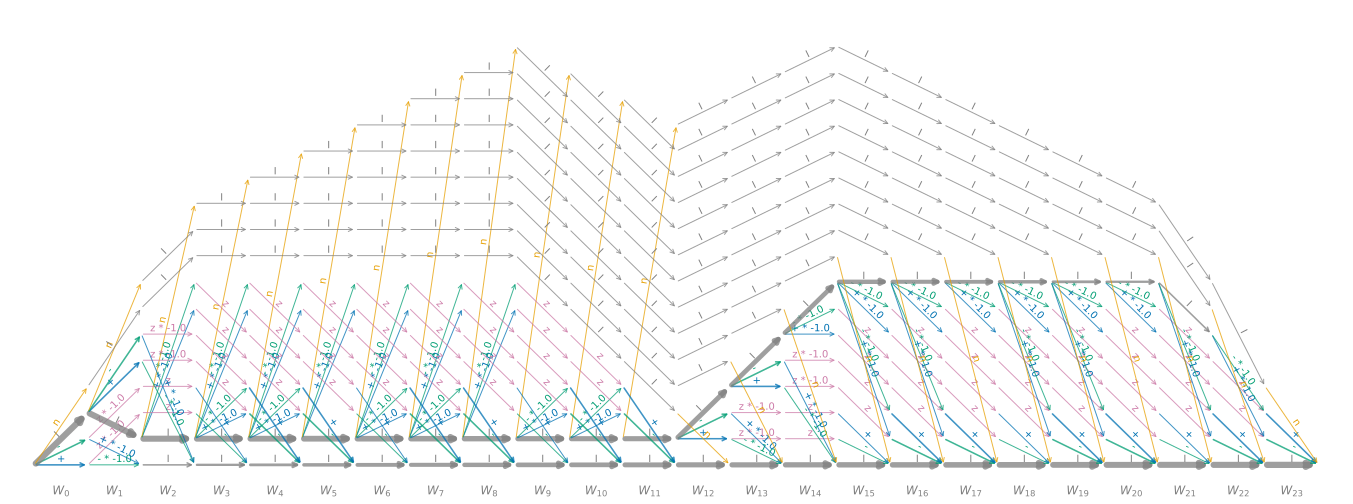

In [48]:
H.draw_state_machine()

In [50]:
mpo = H.build_mpo()
mpo.show()

│4│8│11│12│13│14│15│16│17│16│15│14│15│16│17│16│15│14│13│12│11│8│4│
●─●─●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●─●─●
│ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ │ │


In [51]:
mpo.compress()
mpo.show()

│4│8│11│12│13│14│15│16│17│16│15│14│15│16│17│16│15│14│13│12│11│8│4│
●─<─<──<──<──<──<──<──<──<──<──<──<──<──<──<──<──<──<──<──<──<─<─<
│ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ │ │


Althought the method is a simple greedy one, for semi-local hamiltonians like
here it can find the optimal solution (thus compressing hasn't changed 
anything).